In [1]:
import unittest

import numpy as np
from PIL import Image
from PIL import ImageDraw
import cv2
import chainer
from chainer import Variable
import matplotlib.image as mpimg
from models.proposal_layer import ProposalLayer
from models.bbox_transform import bbox_transform
from models.generate_anchors import generate_anchors as generate_anchors
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'

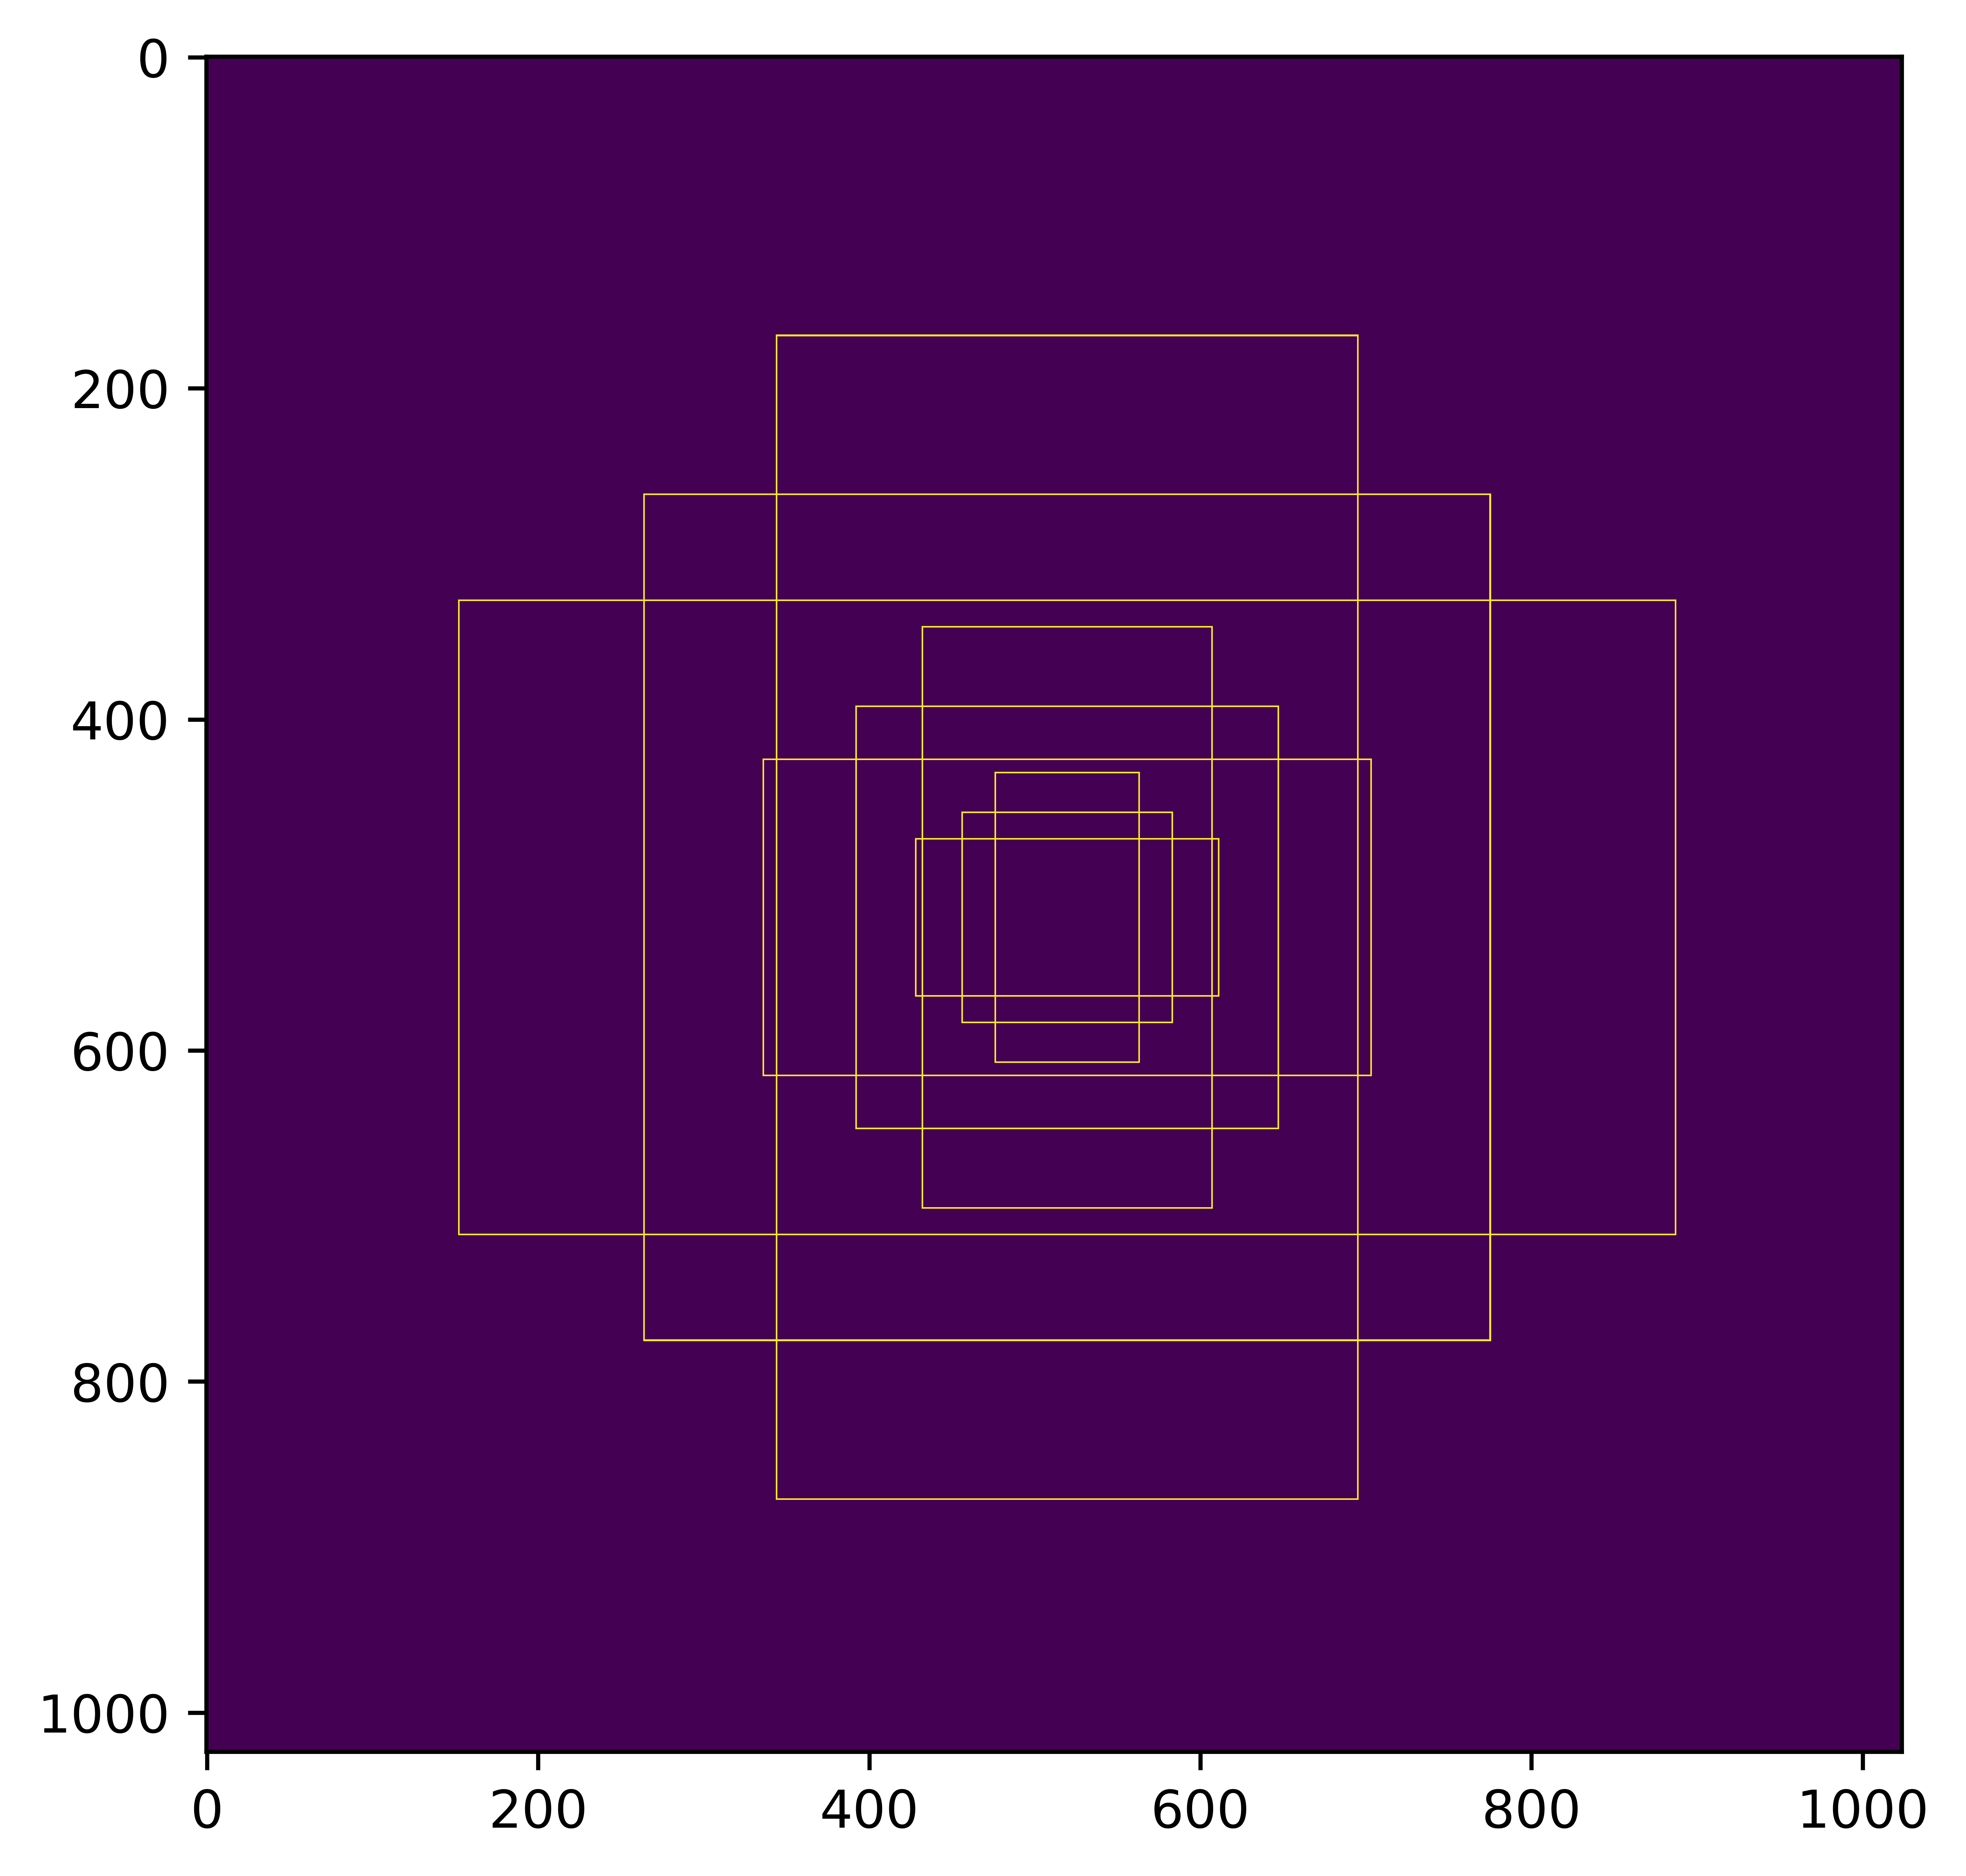

In [2]:
#anchor generate
for bs, r, s in [[15, (0.5, 1, 2), (4, 8, 16, 32)],
                 [15, (0.5, 1, 2), (8, 16, 32)]]:
    anchors = generate_anchors(bs, r, s)
    canvas = Image.fromarray(np.zeros((1024, 1024), dtype='u1'))
    for rec in anchors:
        rec += 512
        draw = ImageDraw.Draw(canvas)
        x0, y0, x1, y1 = rec
        draw.rectangle([x0, y0, x1, y1], None, 255)
    #plt.figure(figsize = (12,6))
    #plt.imshow(canvas)
    #plt.show()
    canvas.save('tests/anchors_{}.png'.format('-'.join([str(a) for a in s])))
anchor_img = mpimg.imread('./tests/anchors_8-16-32.png')
#plt.figure(figsize=(10,10))
plt.figure(figsize = (9,6), dpi = 960)
plt.imshow(anchor_img)

In [3]:
feat_stride = 16
anchor_scales = [8, 16, 32]
proposal_layer = ProposalLayer()
n_anchors = proposal_layer._num_anchors
print(n_anchors)
mat = np.array(proposal_layer._generate_all_bbox(16,16), dtype = np.float32)
print(mat.shape)

9
(2304, 4)


In [4]:
print(mat[0])
boxes = mat

[-84. -40.  99.  55.]


In [5]:
widths = boxes[:, 2] - boxes[:, 0] + 1.0
heights = boxes[:, 3] - boxes[:, 1] + 1.0
ctr_x = boxes[:, 0] + 0.5 * widths
ctr_y = boxes[:, 1] + 0.5 * heights

In [6]:
print(np.min(widths))
print(np.max(heights))
print(np.min(ctr_x))
print(np.max(ctr_y))

88.0
704.0
8.0
248.0


(2400, 4)


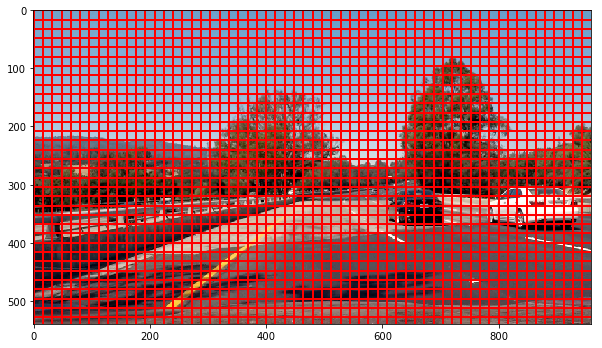

In [7]:
#shifts display on the original image
feat_w = 60
feat_h = 40
shift_x = np.arange(0, feat_w) * feat_stride
shift_y = np.arange(0, feat_h) * feat_stride
shift_x, shift_y = np.meshgrid(shift_x, shift_y)
shifts = np.vstack((shift_x.ravel(), shift_y.ravel(),
                    shift_x.ravel(), shift_y.ravel())).transpose()
print(shifts.shape)
#bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
bbox = ((shifts[:,0], shifts[:,1]),(shifts[:,2],shifts[:,3]))
from PIL import Image
im = Image.open("test4.jpg")
im.thumbnail((960, 640), Image.ANTIALIAS)
plt.imshow(im)
currentAxis = plt.gca()
for i in range(shifts.shape[0]):
    currentAxis.add_patch(plt.Rectangle((shifts[i,0]-feat_stride, shifts[i,1]-feat_stride), shifts[i,2], shifts[i,3], fill=False, edgecolor= 'r', linewidth=2))


In [8]:
x1 = ctr_x - 0.5 * widths +360
y1 = ctr_y - 0.5 * heights +360
x2 = ctr_x + 0.5 * widths +360
y2 = ctr_y + 0.5 * heights +360
print(np.min(x1),np.min(y1),np.min(x2),np.min(y2))
print(np.max(x1),np.max(y1),np.max(x2),np.max(y2))

0.0 16.0 412.0 416.0
564.0 560.0 976.0 960.0


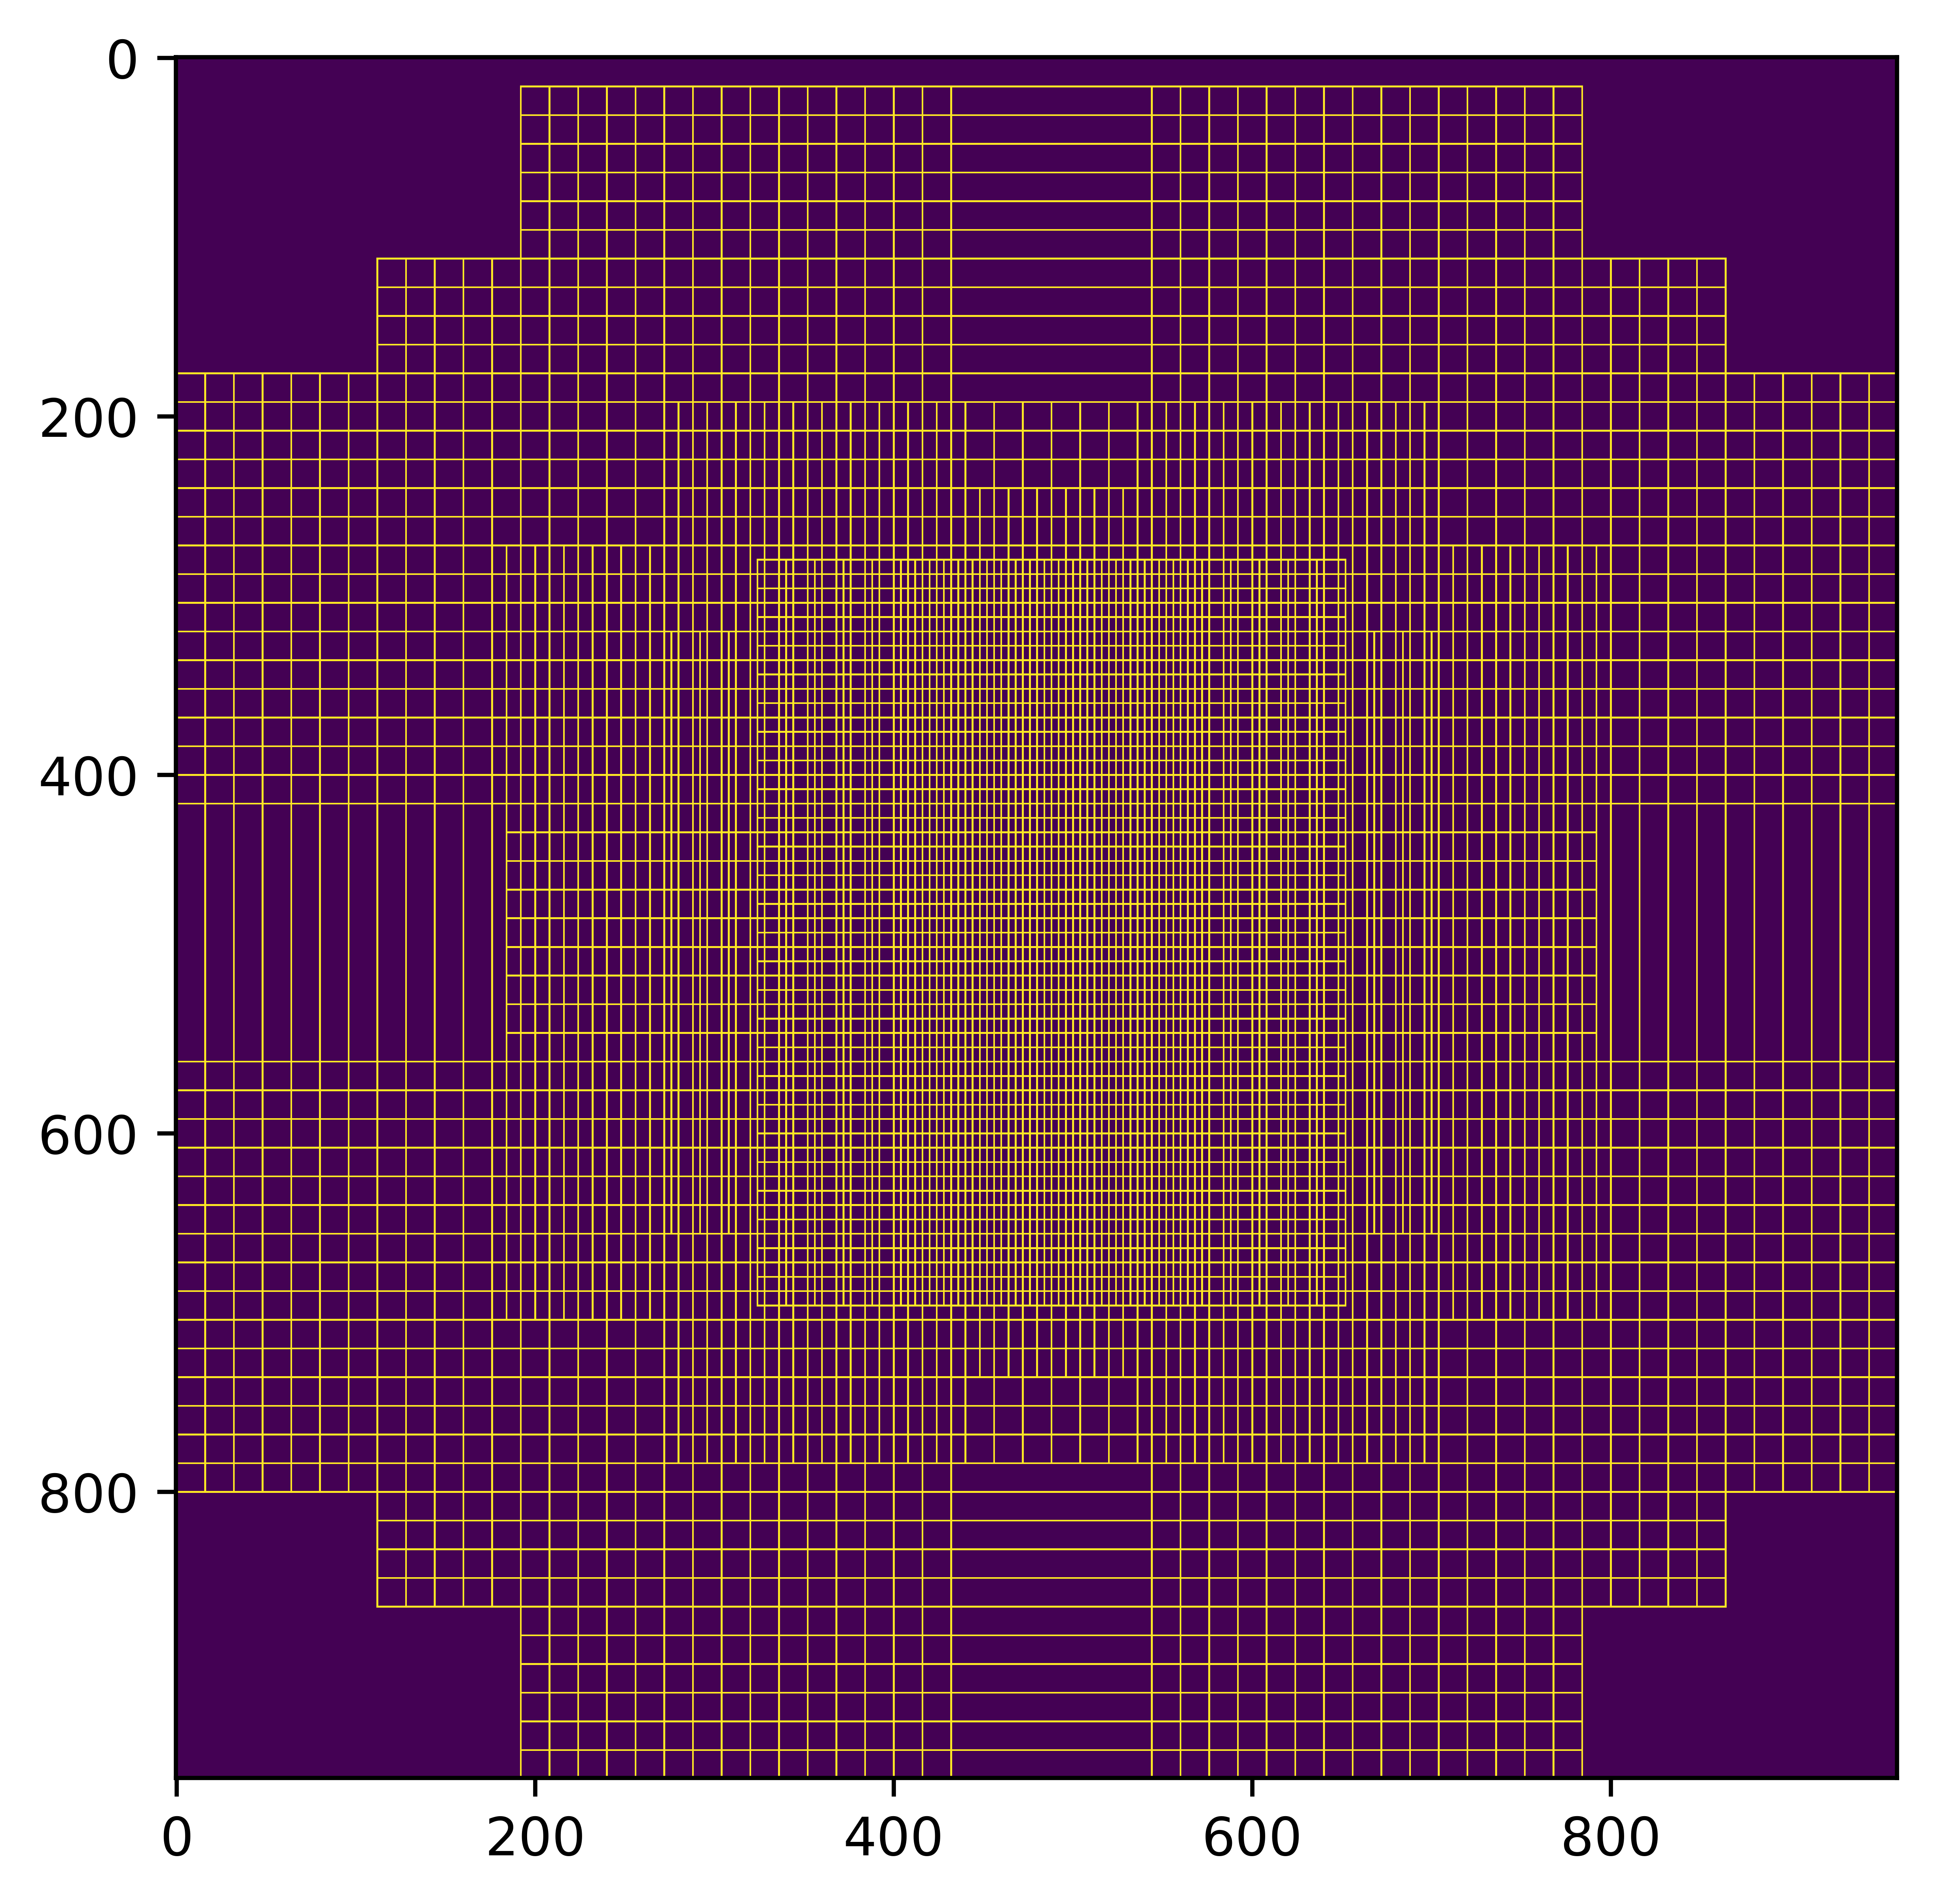

In [9]:
#all anchors(after create anchor windows at all shift points)
canvas = Image.fromarray(np.zeros((960, 960), dtype='u1'))
for i in range(x1.shape[0]):
    draw = ImageDraw.Draw(canvas)
    draw.rectangle([x1[i], y1[i], x2[i], y2[i]], None, 255)
canvas.save('tests/anchor_box_{}.png'.format('-'.join([str(a) for a in s])))
anchor_img = mpimg.imread('./tests/anchor_box_8-16-32.png')
#plt.figure(figsize=(10,10))
plt.figure(figsize = (9,6), dpi = 960)
plt.imshow(anchor_img)

In [10]:
# Start faster rcnn conv5_3 feature extract
import chainer
import chainer.links as L
from chainer import optimizers
import chainer.functions as F
from chainer import Variable
import math
import numpy as np

In [11]:
class VGG(chainer.Chain):
    def __init__(self):
        super(VGG, self).__init__(
            conv1_1=L.Convolution2D(3, 64, 3, stride=1, pad=1),
            conv1_2=L.Convolution2D(64, 64, 3, stride=1, pad=1),

            conv2_1=L.Convolution2D(64, 128, 3, stride=1, pad=1),
            conv2_2=L.Convolution2D(128, 128, 3, stride=1, pad=1),

            conv3_1=L.Convolution2D(128, 256, 3, stride=1, pad=1),
            conv3_2=L.Convolution2D(256, 256, 3, stride=1, pad=1),
            conv3_3=L.Convolution2D(256, 256, 3, stride=1, pad=1),

            conv4_1=L.Convolution2D(256, 512, 3, stride=1, pad=1),
            conv4_2=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv4_3=L.Convolution2D(512, 512, 3, stride=1, pad=1),

            conv5_1=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_2=L.Convolution2D(512, 512, 3, stride=1, pad=1),
            conv5_3=L.Convolution2D(512, 512, 3, stride=1, pad=1)
        )
        self.train = False
        self.mean = np.asarray(120, dtype=np.float32)

    def preprocess(self, image):
        return np.rollaxis(image - self.mean, 2)

    def __call__(self, x):
        y1 = F.relu(self.conv1_2(F.relu(self.conv1_1(x))))
        h = F.max_pooling_2d(y1, 2, stride=2)
        y2 = F.relu(self.conv2_2(F.relu(self.conv2_1(h))))
        h = F.max_pooling_2d(y2, 2, stride=2)
        y3 = F.relu(self.conv3_3(F.relu(self.conv3_2(F.relu(self.conv3_1(h))))))
        h = F.max_pooling_2d(y3, 2, stride=2)
        y4 = F.relu(self.conv4_3(F.relu(self.conv4_2(F.relu(self.conv4_1(h))))))
        h = F.max_pooling_2d(y4, 2, stride=2)
        y5 = F.relu(self.conv5_3(F.relu(self.conv5_2(F.relu(self.conv5_1(h))))))
        return [y1, y2, y3, y4, y5]

In [12]:
from chainer import link
from chainer.links.caffe import CaffeFunction
from chainer import serializers

In [272]:
def copy_model(src, dst):
    assert isinstance(src, link.Chain)
    assert isinstance(dst, link.Chain)
    for child in src.children():
        if child.name not in dst.__dict__: continue
        dst_child = dst[child.name]
        if type(child) != type(dst_child): continue
        if isinstance(child, link.Chain):
            copy_model(child, dst_child)
        if isinstance(child, link.Link):
            match = True
            for a, b in zip(child.namedparams(), dst_child.namedparams()):
                if a[0] != b[0]:
                    match = False
                    break
                if a[1].data.shape != b[1].data.shape:
                    match = False
                    break
            if not match:
                print ('Ignore %s because of parameter mismatch' % child.name)
                continue
            for a, b in zip(child.namedparams(), dst_child.namedparams()):
                b[1].data = a[1].data
            print ('Copy %s' % child.name)

In [13]:
vgg = VGG()

In [273]:
#convert the caffemodel(VGG16) to chainer
print ('load VGG16 caffemodel')
ref = CaffeFunction('VGG_ILSVRC_16_layers.caffemodel')
vgg = VGG()
print ('copy weights')
copy_model(ref, vgg)
print ('save "vgg16.model"')
serializers.save_npz('vgg16.model', vgg)

load VGG16 caffemodel
copy weights
Copy conv1_1
Copy conv1_2
Copy conv2_1
Copy conv2_2
Copy conv3_1
Copy conv3_2
Copy conv3_3
Copy conv4_1
Copy conv4_2
Copy conv4_3
Copy conv5_1
Copy conv5_2
Copy conv5_3
save "vgg16.model"


In [14]:
#load test image and output the featuremaps 
from chainer import cuda
#load model
serializers.load_npz('vgg16.model', vgg)
#gpu mode
#cuda.get_device(0).use()
vgg.to_cpu()
xp = np#cuda.cupy
#preprocessing for input image
style = vgg.preprocess(np.asarray(Image.open('test4.jpg').convert('RGB').resize((960,640)), dtype=np.float32))
style = xp.asarray(style, dtype=xp.float32)
#feature extract, so batchsize = 1
batchsize = 1
style_b = xp.zeros((batchsize,) + style.shape, dtype=xp.float32)
for i in range(batchsize):
    style_b[i] = style
#feature extract & output the featuremap
#feature_s = vgg(Variable(style_b, volatile=True))

In [15]:
feature_s = vgg(Variable(style_b, volatile=True))

In [16]:
#featuremap dim of conv5_3
print(np.array(feature_s[4].data).shape)

(1, 512, 40, 60)


In [17]:
def keep_inside(anchors, img_info):
    """Calc indicies of anchors which are inside of the image size.

    Calc indicies of anchors which are located completely inside of the image
    whose size is speficied by img_info ((height, width, scale)-shaped array).
    """
    with cuda.get_device_from_array(anchors) as d:
        xp = cuda.get_array_module(anchors)
        if d.id >= 0:
            img_info = cuda.to_gpu(img_info, d)
            assert anchors.device == img_info.device

        inds_inside = xp.where(
            (anchors[:, 0] >= 0) &
            (anchors[:, 1] >= 0) &
            (anchors[:, 2] < img_info[1]) &  # width
            (anchors[:, 3] < img_info[0])  # height
        )[0]
        return inds_inside, anchors[inds_inside]

In [18]:
all_bbox = np.asarray(proposal_layer._generate_all_bbox(16, 16))
img_info = (640,960)

In [19]:
#inside anchor box 
inds_inside, all_inside_bbox = keep_inside(all_bbox, img_info)

In [20]:
#simple one, only forward within random value initializes
from chainer import initializers
class RegionProposalNetwork(chainer.Chain):
    def __init__(self):
        feat_stride=16
        anchor_ratios=(0.5, 1, 2)
        anchor_scales=(8, 16, 32)
        w = initializers.Normal(0.01)
        n_anchors = 9
        super(RegionProposalNetwork, self).__init__(
            rpn_conv_3x3=L.Convolution2D(512, 512, 3, 1, 1, initialW=w),
            rpn_cls_score=L.Convolution2D(
                512, 2 * 9, 1, 1, 0, initialW=w),
            rpn_bbox_pred=L.Convolution2D(
                512, 4 * 9, 1, 1, 0, initialW=w)
        )
        self._train = True

    def __call__(self, x, img_info = None, gt_boxes=None):
        h = F.relu(self.rpn_conv_3x3(x))
        rpn_cls_score = self.rpn_cls_score(h)
        rpn_cls_prob = F.softmax(rpn_cls_score)
        rpn_bbox_pred = self.rpn_bbox_pred(h)
        return rpn_cls_score,rpn_cls_prob,rpn_bbox_pred

In [21]:
rpn = RegionProposalNetwork()
rpn.to_cpu()

In [22]:
data = np.array(feature_s[4].data)
print(data.shape)

(1, 512, 40, 60)


In [23]:
rpn_cls_score,rpn_cls_prob,rpn_bbox_pred = rpn(Variable(data, volatile=True))

In [24]:
#bbox_pred = np.array(rpn_bbox_pred.data)
print(np.array(rpn_bbox_pred.data).shape)

(1, 36, 40, 60)


In [25]:
feat_stride=16
anchor_ratios=(0.5, 1, 2)
anchor_scales=(8, 16, 32)

In [26]:
rpn_bbox_pred = rpn_bbox_pred.data[0]

In [27]:
from models.proposal_layer import ProposalLayer
proposal_layer = ProposalLayer(feat_stride, anchor_ratios, anchor_scales)
all_bbox = proposal_layer._generate_all_bbox_use_array_info(rpn_bbox_pred)

In [28]:
print(np.array(all_bbox).shape)

(21600, 4)


In [29]:
bbox_trans = rpn_bbox_pred.transpose(1, 2, 0).reshape(-1, 4)

In [30]:
from models.bbox_transform import bbox_transform_inv
from models.bbox_transform import clip_boxes
proposals = bbox_transform_inv(all_bbox, bbox_trans)
proposals = clip_boxes(proposals, (640,960))

In [31]:
print(proposals)
print(np.array(proposals).shape)

[[   0.            0.           52.77120209    1.11845398]
 [   0.           12.74034119  141.2721405   160.7885437 ]
 [   0.            0.          685.84326172  221.30505371]
 ..., 
 [ 899.55859375  516.23901367  959.          639.        ]
 [ 837.54626465  525.44689941  959.          639.        ]
 [ 724.19812012  315.39920044  959.          639.        ]]
(21600, 4)


In [32]:
pred = np.array(proposals)

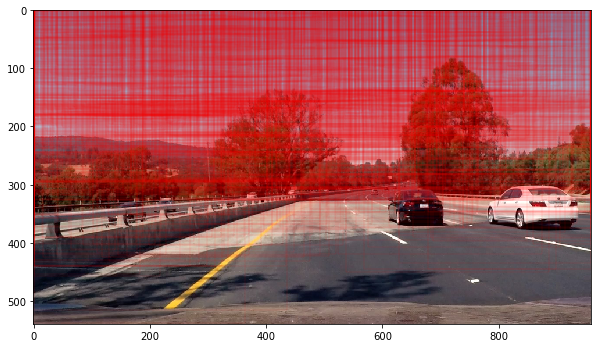

In [47]:
im = Image.open("test4.jpg")
im.thumbnail((960, 640), Image.ANTIALIAS)
plt.imshow(im)
currentAxis = plt.gca()
for i in range(shifts.shape[0]):
    currentAxis.add_patch(plt.Rectangle((pred[i,0], pred[i,1]), pred[i,2]-pred[i,0], pred[i,3]-pred[i,1], fill=False, edgecolor= 'r', linewidth=0.1))

In [175]:
#scan the minimum anchor box
print(np.min(pred[:,3]-pred[:,1]))
print(np.min(pred[:,2]-pred[:,0]))
print(np.max(pred[:,3]-pred[:,1]))
print(np.max(pred[:,2]-pred[:,0]))

0.0
0.0
639.0
959.0


(2, 4)


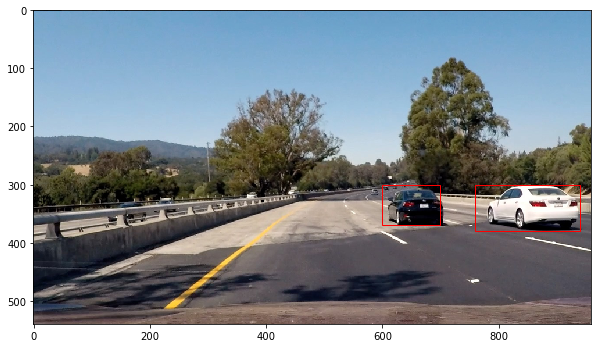

In [45]:
#add ground truth
gt_boxes = np.array([[600,300,700,370],[760,300,940,380]])
print(gt_boxes.shape)
im = Image.open("test4.jpg")
im.thumbnail((960, 640), Image.ANTIALIAS)
plt.imshow(im)
currentAxis = plt.gca()
for i in range(2):
    currentAxis.add_patch(plt.Rectangle((gt_boxes[i,0], gt_boxes[i,1]), gt_boxes[i,2]-gt_boxes[i,0], gt_boxes[i,3]-gt_boxes[i,1], fill=False, edgecolor= 'r', linewidth=1))

In [96]:
from models.anchor_target_layer import AnchorTargetLayer
#img_info = (640,960)
img_info = Variable(np.array([[640, 960]], dtype=np.int32))
#gt_boxes = np.array([[600,300,700,370],[760,300,940,380]])
gt_boxes = Variable(np.array([[
            [600, 300, 700, 370, 0],
            [760, 300, 940, 380, 0]
        ]], dtype=np.float32))
feat_h, feat_w = rpn_cls_prob.shape[2:]
# Get target values to calc losses
anchor_target_layer = AnchorTargetLayer(feat_stride, anchor_ratios, anchor_scales)
bbox_labels, bbox_reg_targets, inds_inside, n_all_bbox = anchor_target_layer(feat_h, feat_w, gt_boxes, img_info)

In [110]:
print(np.array(bbox_labels).shape)
print(np.array(bbox_reg_targets).shape)
print(np.array(inds_inside).shape)
print(np.array(n_all_bbox))

(8384,)
(8384, 4)
(8384,)
21600


[[ 600.  300.  701.  371.]
 [ 600.  300.  701.  371.]
 [ 600.  300.  701.  371.]
 ..., 
 [ 600.  300.  701.  371.]
 [ 600.  300.  701.  371.]
 [ 600.  300.  701.  371.]]
(8384, 4)


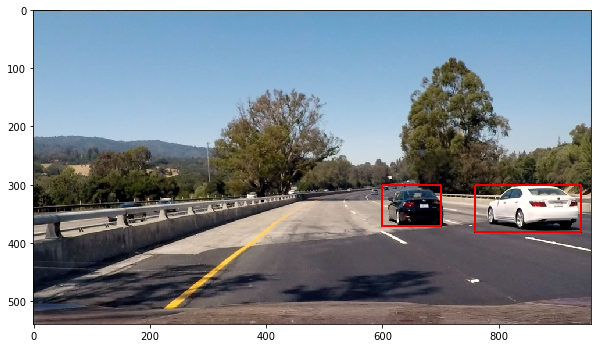

In [118]:
#print(gt_boxes.shape)
#bbox_trans = bbox_reg_targets.transpose(1, 2, 0).reshape(-1, 4)
proposals = bbox_transform_inv(all_bbox[inds_inside], bbox_reg_targets)
proposals = clip_boxes(proposals, (640,960))
print(proposals)
print(np.array(proposals).shape)
points = np.array(proposals)
im = Image.open("test4.jpg")
im.thumbnail((960, 640), Image.ANTIALIAS)
plt.imshow(im)
currentAxis = plt.gca()
for i in range(np.array(bbox_labels).shape[0]):
        currentAxis.add_patch(plt.Rectangle((points[i,0], points[i,1]), points[i,2]-points[i,0], points[i,3]-points[i,1], fill=False, edgecolor= 'r', linewidth=0.1))

In [122]:
labels = np.array(bbox_labels)
postive_counter = 0
negative_counter = 0
for i in range(np.array(bbox_labels).shape[0]):
    if(labels[i] == 1):
        postive_counter += 1
    elif(labels[i] == 0):
        negative_counter += 1
    else:
        continue
print(postive_counter, negative_counter)

11 245


In [176]:
#detection here

In [177]:
import chainer
import cv2 as cv
from chainer import serializers
from chainer.cuda import to_gpu
from models.cpu_nms import cpu_nms as nms
from models.faster_rcnn import FasterRCNN
from models.vgg16 import VGG16Prev

In [178]:
def get_model(gpu):
    model = FasterRCNN(trunk_class=VGG16Prev)
    model.rcnn_train = False
    model.rpn_train = False
    serializers.load_npz('data/VGG16_faster_rcnn_final.model', model)
    return model

In [179]:
def img_preprocessing(orig_img, pixel_means, max_size=1000, scale=600):
    img = orig_img.astype(np.float32, copy=True)
    img -= pixel_means
    im_size_min = np.min(img.shape[0:2])
    im_size_max = np.max(img.shape[0:2])
    im_scale = float(scale) / float(im_size_min)
    if np.round(im_scale * im_size_max) > max_size:
        im_scale = float(max_size) / float(im_size_max)
    img = cv.resize(img, None, None, fx=im_scale, fy=im_scale,
                    interpolation=cv.INTER_LINEAR)

    return img.transpose([2, 0, 1]).astype(np.float32), im_scale

In [180]:
def draw_result(out, im_scale, clss, bbox, nms_thresh, conf):
    CV_AA = 16
    for cls_id in range(1, 21):
        _cls = clss[:, cls_id][:, np.newaxis]
        _bbx = bbox[:, cls_id * 4: (cls_id + 1) * 4]
        dets = np.hstack((_bbx, _cls))
        keep = nms(dets, nms_thresh)
        dets = dets[keep, :]

        inds = np.where(dets[:, -1] >= conf)[0]
        for i in inds:
            x1, y1, x2, y2 = map(int, dets[i, :4] / im_scale)
            cv.rectangle(out, (x1, y1), (x2, y2), (0, 0, 255), 2, CV_AA)
            ret, baseline = cv.getTextSize(
                CLASSES[cls_id], cv.FONT_HERSHEY_SIMPLEX, 0.8, 1)
            cv.rectangle(out, (x1, y2 - ret[1] - baseline),
                         (x1 + ret[0], y2), (0, 0, 255), -1)
            cv.putText(out, CLASSES[cls_id], (x1, y2 - baseline),
                       cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1, CV_AA)

    return out

In [181]:
#cpu use only
model = get_model(gpu=-1)

In [182]:
model.to_cpu()

In [198]:
PIXEL_MEANS = np.array([[[102.9801, 115.9465, 122.7717]]])
image = cv2.imread("test_images/straight_lines1.jpg")
orig_image=np.array(orig_image, dtype=np.float)
print('orig_image:', orig_image.shape)
img, im_scale = img_preprocessing(orig_image, PIXEL_MEANS)
img = np.expand_dims(img, axis=0)
print('img:', img.shape, im_scale)

orig_image: (375, 500, 3)
img: (1, 3, 600, 800) 1.6


In [199]:
img = chainer.Variable(img, volatile=True)
img_info = chainer.Variable(np.array([[img.shape[2], img.shape[2]]]))
cls_score, bbox_pred = model(img, img_info)
cls_score = cls_score.data

(300, 84)
(375, 500, 3)


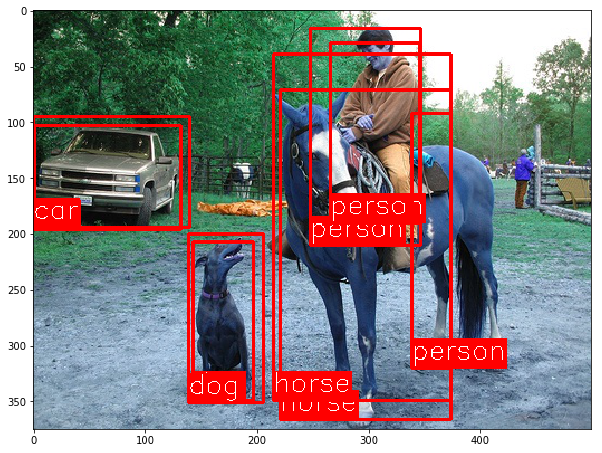

In [205]:
CLASSES = ('__background__',
           'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair',
           'cow', 'diningtable', 'dog', 'horse',
           'motorbike', 'person', 'pottedplant',
           'sheep', 'sofa', 'train', 'tvmonitor')
result = draw_result(orig_image, im_scale, cls_score, bbox_pred,
                         0.3, 0.3)
print(np.array(bbox_pred).shape)
#result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
print(result.shape)
result = np.uint8(result)
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))

In [ ]:
#we can see there have not only one bbox in one object.